> # **Build a Semantic Similarity Engine**

- Build a system that measures semantic similarity between two texts (sentence, paragraph, or document) based on meaning, not just keyword overlap.
- This is highly relevant to NLP track and future work in:
    - Resume screening
    - Complaint clustering
    - Voice agent intent matching
    - Document retrieval
    - Chat memory matching

In [4]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 46.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
# import the libraries
import spacy
nlp = spacy.load("en_core_web_md")

> ## Step 1 — Load pretrained embeddings

In [113]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.6 MB/s eta 0:00:00


In [114]:
import gensim.downloader as api             # Gensim provides a built-in API to download pretrained embeddings

print(api.info()['models'].keys())          # Check available models

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [115]:
word2vec = api.load('word2vec-google-news-300')
glove = api.load('glove-wiki-gigaword-300')
fasttext = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


> - **Verify Model Loaded**

In [118]:
print(word2vec.vector_size)
"king" in word2vec

300


True

In [129]:
text1 =  '1111 Build a system that measures,,, semantic similarity between two texts (sentence, paragraph, or document) based on meaning,not just keyword overlap.'
text2 = ' I love learning NLP'

> ## Step 2 — Text Preprocessing

In [144]:
def text_preprocess(input, remove_stopword=False):

  if isinstance(input, str):   # used to check the type
    doc = nlp(input)

    if remove_stopword:
      return [token.text.lower() for token in doc if token.is_alpha and not token.is_punct and not token.is_stop]
    else:
      return [token.text.lower() for token in doc if token.is_alpha and not token.is_punct]

  elif isinstance(input, list):
    preprocess_text = []

    docs = nlp.pipe(input)

    if remove_stopword:
      tokens = [token.text.lower() for doc in docs for token in doc if not token.is_punct and token.is_alpha and not token.is_stop]

    else:
      tokens = [token.text.lower() for doc in docs for token in doc if not token.is_punct and token.is_alpha ]

    preprocess_text.append(tokens)

  return preprocess_text


In [145]:
# pre_text = text_preprocess(text, remove_stopword=True)
# print(pre_text)

> ## Step 3 — Convert Words to Vectors
- This step transforms tokens (words) into numerical vectors so that a machine can measure meaning mathematically.
- So we convert every word into a fixed-length dense vector called a word embedding.

> ### Models that generate these embeddings:
- Word2Vec
- GloVe
- FastText

In [146]:
import numpy as np

def words_to_vectors(input, model):
  vectors = []

  for word in input:
    if word in model:
      vectors.append(model[word])

  return np.array(vectors)

> ## Step 4 — Create Sentence Embedding (Mean Pooling)

In [147]:
def sentences_to_vectors(input, model):
  vectors = words_to_vectors(input, model)

  if len(vectors) == 0:
    return np.zeros(model.vector_size) # fallback

  else:
    return np.mean(vectors, axis=0)


> ## Build Similarity Function
### Why Cosine Similarity?
- It measures angle between vectors
- Independent of sentence length
- Works well for embeddings

 Range:

1 → identical meaning

0 → unrelated

-1 → opposite direction (rare)

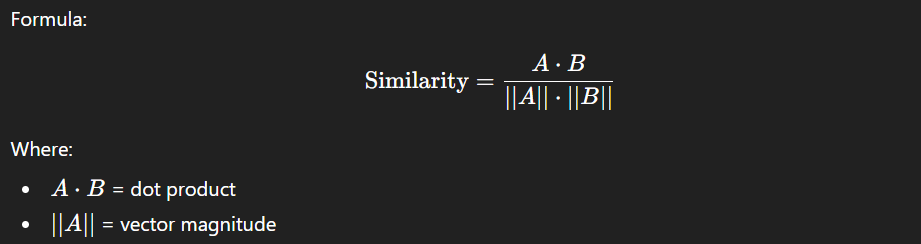

In [163]:
def cosine_similarity(vec1, vec2):

  dot_product = np.dot(vec1, vec2)

  norm_vec1 = np.linalg.norm(vec1)      # linear algebar If 0 → all words were OOV
  norm_vec2 = np.linalg.norm(vec2)

  if norm_vec1 == 0 or norm_vec2 == 0:
    return 0

  return dot_product / (norm_vec1 * norm_vec2)

def cosine_similarity_manual(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

> ## Full Semantic Similarity Engine

In [168]:
def semantic_similarity(input1, input2, model):

  text_processed_1 = text_preprocess(input1, True)
  text_processed_2 = text_preprocess(input2, True)

  vec1 = sentences_to_vectors(text_processed_1, model)
  vec2 = sentences_to_vectors(text_processed_2, model)

  # similarity = cosine_similarity(vec1.reshape(1, -1),
  #                               vec2.reshape(1, -1))

  similarity_man = cosine_similarity_manual(vec1, vec2)

  return similarity_man

### Another way with sklearn

In [165]:
from sklearn.metrics.pairwise import cosine_similarity

def semantic_sim_sk(input1, input2, model):
  text_processed_1 = text_preprocess(input1, True)
  text_processed_2 = text_preprocess(input2, True)

  vec1 = sentences_to_vectors(text_processed_1, model)
  vec2 = sentences_to_vectors(text_processed_2, model)

  similarity_sk = cosine_similarity(vec1.reshape(1, -1),
                               vec2.reshape(1, -1))[0][0]

  return similarity_sk

In [166]:
results_sk = {}

results_sk['word2vec'] = semantic_sim_sk(text1, text2, word2vec)
results_sk['glove'] = semantic_sim_sk(text1, text2, glove)
results_sk['fasttext'] = semantic_sim_sk(text1, text2, fasttext)

print(results_sk)

{'word2vec': np.float32(0.23472719), 'glove': np.float32(0.27556342), 'fasttext': np.float32(0.59083986)}


In [167]:
results = {}

results['word2vec'] = semantic_similarity(text1, text2, word2vec)
results['glove'] = semantic_similarity(text1, text2, glove)
results['fasttext'] = semantic_similarity(text1, text2, fasttext)

print(results)

{'word2vec': np.float32(0.23472714), 'glove': np.float32(0.27556342), 'fasttext': np.float32(0.59083986)}


> ## Evaluate on STS dataset
- You can load using HuggingFace

In [134]:
!pip install dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.47
    Uninstalling SQLAlchemy-2.0.47:
      Successfully uninstalled SQLAlchemy-2.0.47
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.25.1 requires sqlalchemy<3.0.0,>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [136]:
from datasets import load_dataset

dataset = load_dataset("stsb_multi_mt", name="en")

test_case = dataset['test']

print(test_case.shape)
print(test_case[0:4])

README.md: 0.00B [00:00, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/470k [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

en/dev-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

(1379, 3)
{'sentence1': ['A girl is styling her hair.', 'A group of men play soccer on the beach.', "One woman is measuring another woman's ankle.", 'A man is cutting up a cucumber.'], 'sentence2': ['A girl is brushing her hair.', 'A group of boys are playing soccer on the beach.', "A woman measures another woman's ankle.", 'A man is slicing a cucumber.'], 'similarity_score': [2.5, 3.5999999046325684, 5.0, 4.199999809265137]}


> ## Compute Model Similarity

In [171]:
print(test_case['sentence1'][0], test_case['sentence2'][0])

text3 = test_case['sentence1'][0]
text4 = test_case['sentence2'][0]

pre_score = semantic_similarity(text3, text4, word2vec)

original_score = test_case['similarity_score'][0]
human_score = original_score / 5

print(f'predicted score {pre_score} \noriginal score by human {human_score}')

A girl is styling her hair. A girl is brushing her hair.
predicted score 0.7876443266868591 
original score by human 0.5


In [189]:
def compute_overall_score(model):

    true_scores = []
    pred_scores = []

    # Precompute embeddings
    sent1_vectors = [
        sentences_to_vectors(text_preprocess(s1, True), model)
        for s1 in test_case['sentence1']
    ]

    sent2_vectors = [
        sentences_to_vectors(text_preprocess(s2, True), model)
        for s2 in test_case['sentence2']
    ]

    for vec1, vec2, score in zip(
        sent1_vectors,
        sent2_vectors,
        test_case['similarity_score']
    ):

        pred = cosine_similarity(vec1.reshape(1, -1),
                                 vec2.reshape(1, -1))[0][0]

        true_scores.append(score / 5)
        pred_scores.append(pred)

    return true_scores, pred_scores

In [ ]:
# or use this it will o(n) time complexity

def compute_overall_score(model):

    true_scores = []
    pred_scores = []

    for s1, s2, score in zip(
        test_case['sentence1'],
        test_case['sentence2'],
        test_case['similarity_score']
    ):

        pred = semantic_similarity(s1, s2, model)

        true_scores.append(score / 5)   # normalize 0–1
        pred_scores.append(pred)

    return true_scores, pred_scores

In [190]:
t_score, p_score = compute_overall_score(word2vec)
print(t_score[0:20], p_score[0:20])

[0.5, 0.7199999809265136, 1.0, 0.8399999618530274, 0.3, 0.3599999904632568, 0.7, 0.4400000095367432, 0.4400000095367432, 0.3427999973297119, 0.3427999973297119, 1.0, 0.12000000476837158, 0.8800000190734864, 0.4, 0.3599999904632568, 0.8800000190734864, 0.7199999809265136, 0.7199999809265136, 0.24000000953674316] [np.float32(0.7876443), np.float32(0.9277586), np.float32(0.8900621), np.float32(0.897461), np.float32(0.7795393), np.float32(0.76570725), np.float32(0.9106944), np.float32(0.8553066), np.float32(0.875321), np.float32(0.8444941), np.float32(0.8444941), np.float32(0.88523996), np.float32(0.50751364), np.float32(0.81272465), np.float32(0.7412664), np.float32(0.82270515), np.float32(0.81047374), np.float32(0.9399673), np.float32(0.7189353), np.float32(0.555463)]


### Pearson measures:
Linear agreement between:

Human judgement

Model output

In [192]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(t_score, p_score)
spearman_corr, _ = spearmanr(t_score, p_score)

print('Pearson correlation: %.3f' % pearson_corr)
print('Spearman correlation: %.3f' % spearman_corr)

Pearson correlation: 0.618
Spearman correlation: 0.642


> ## Plot Scatter Graph

In [193]:
print(len(t_score))
print(len(p_score))

1379
1379


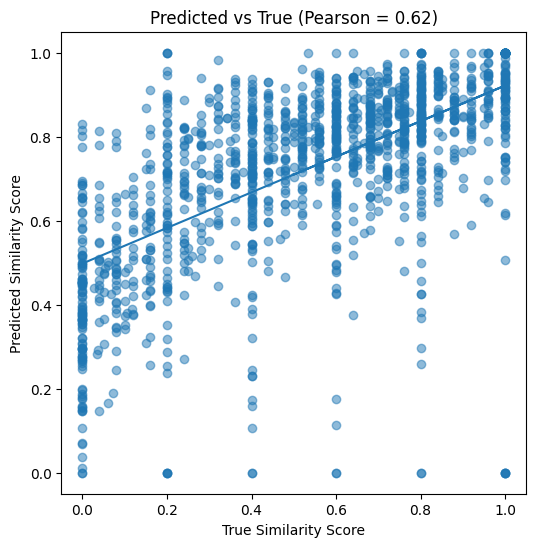

In [195]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))

plt.scatter(t_score, p_score, alpha=0.5)

z = np.polyfit(t_score, p_score, 1)         # Add Trend Line
p = np.poly1d(z)                            # Add Trend Line

plt.plot(t_score, p(t_score))               # Add Trend Line

# Diagonal reference line
# plt.plot([0,1], [0,1])

plt.xlabel("True Similarity Score")
plt.ylabel("Predicted Similarity Score")
plt.title(f"Predicted vs True (Pearson = {pearson_corr:.2f})")

plt.show()